# Logit Analysis
This notebook will analyse the logit models in detail.'

<small>**NOTE:** This notebook was used on top of the `ema_rwd_statistic.py` script for further Logit analysis.</small>

<small>**NOTE:** Extra analysis on top of final analysis. Added in appendix.</small>

First we will import the needed libraries:

In [1]:
import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import LogitResults
from statsmodels.iolib.table import SimpleTable
from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set_theme('paper', 'white')

And load the model and variables:

In [9]:
which = 'protocol'
# which = 'results'

exclusive_col = (
    'data_collection_days_difference' 
    if which == 'protocol' else 
    'final_report_days_difference'
)

results = LogitResults.load(f'../../output/ema_rwd/multivariate_models/models/{which}/all.pickle')

variables = pd.read_excel(
    f'../../output/ema_rwd/ema_rwd_final_statistics_variables.xlsx', 
    sheet_name='due_protocol' if which == 'protocol' else 'due_result',
    index_col=0
)

We will show the summary-tables of the loaded results together with $\textbf{odds ratios}$ and their $\textbf{95\%-CIs}$

In [22]:
# Get coefficients with CI
params = results.params
conf_odds_ratio = np.exp(results.conf_int()).rename(columns={0: '[0.025', 1: '0.975]'})

# Calculate Odds Ratio be exponentiating
odds_ratio = np.exp(params).rename('odds rt').to_frame()
odds_ratio_data = np.round(pd.merge(odds_ratio, conf_odds_ratio, left_index=True, right_index=True), decimals=4)

# Append to table
table = SimpleTable(odds_ratio_data.values, odds_ratio_data.columns.to_list())
summary = results.summary()
summary.tables[1].extend_right(table)

logit_df = pd.DataFrame(
    summary.tables[1].data[1:], columns=['name'] + summary.tables[1].data[0][1:])

exog = pd.DataFrame(data=results.model.exog, columns=results.model.exog_names, index=results.model.data.row_labels)
endog = pd.DataFrame(data=results.model.endog, columns=[results.model.endog_names], index=results.model.data.row_labels)

# summary

## Linearity Checks
We need to check the linearity of continous/ordinal values and their log-odds for logistic regression models

In [23]:
# NOTE: Old version with grouping by patches
# NOTE: Linearity check not needed anymore for registration date (using dummies instead).
# original_encoded_df = pd.read_excel(f'../../output/ema_rwd/ema_rwd_final_statistics_encoded_variables_{which}.xlsx') \
#     .rename(columns=lambda x : x.lower().replace(' ', '_'))

# group_together = 20 * 12

# linearity_df = original_encoded_df[[exclusive_col, results.model.endog_names]] \
#     .rename(columns={results.model.endog_names: 'prob'}) \
#     .assign(**{f'{exclusive_col}_grouped': lambda x : np.floor(x[exclusive_col] / group_together)}) \
#     .set_index(f'{exclusive_col}_grouped') \
#     .groupby(level=0).mean() \
#     .assign(log_odds=lambda x : np.log(x['prob'] / (1 - x['prob'])))

# display(linearity_df)
# linearity_df[['prob', 'log_odds']].plot()

/Users/pedRam/miniconda3/envs/eupas/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,probability,log_odds,size
due_result_year,,,
2003,0.000000,-inf,1
2005,0.000000,-inf,1
2007,0.000000,-inf,1
2010,0.250000,-1.098612,4
2011,0.181818,-1.504077,11
2012,0.461538,-0.154151,13
2013,0.645833,0.600774,48
2014,0.582090,0.331357,67
2015,0.562500,0.251314,96


<Axes: title={'center': 'Plot of data (only entries with more than 1% [N ≥ 15] of the population)'}, xlabel='due_result_year'>

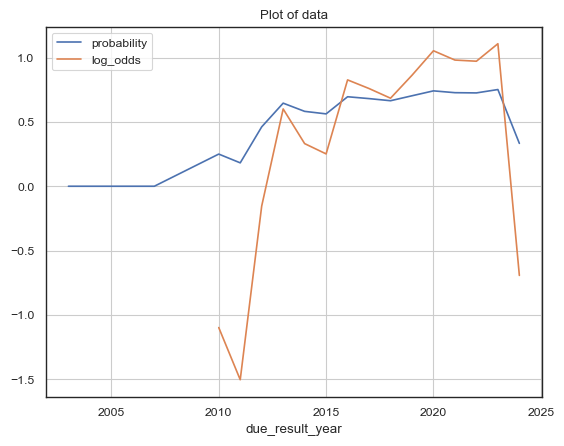

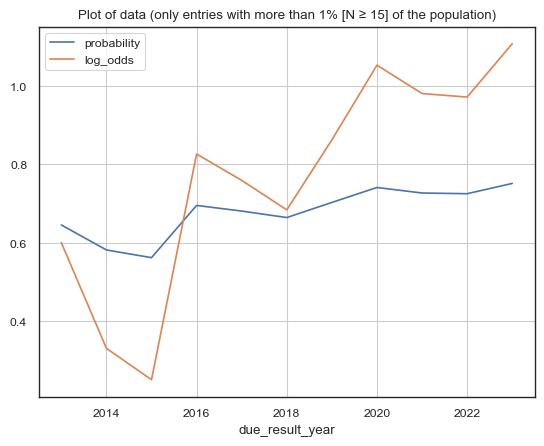

In [24]:
# NOTE: Old version with grouping by due year
# NOTE: Linearity check not needed anymore for registration date (using dummies instead).
continous_variable_grouped = 'due_protocol_year' if which == 'protocol' else 'due_result_year'
linearity_df = variables[[continous_variable_grouped, results.model.endog_names]] \
    .rename(columns={results.model.endog_names: 'probability'}) \
    .set_index(continous_variable_grouped) \
    .groupby(level=0)

linearity_df = linearity_df.mean() \
    .assign(
        log_odds=lambda x : np.log(x['probability'] / (1 - x['probability'])),
        size=linearity_df.size()
    )

display(linearity_df)
linearity_df[['probability', 'log_odds']].plot(
    grid=True, 
    title='Plot of data'
)
linearity_df.loc[linearity_df['size'] >= len(variables) / 100, ['probability', 'log_odds']].plot(
    grid=True, 
    title=f'Plot of data (only entries with more than 1% [N ≥ {np.ceil(len(variables) / 100):.0f}] of the population)'
)

In [25]:
tmp = linearity_df.loc[linearity_df['size'] >= len(variables) / 100, ['probability', 'log_odds']]
mod_tmp = sm.add_constant(tmp['log_odds'], prepend=False).reset_index()

# # Fit and summarize OLS model
mod = sm.OLS(mod_tmp['log_odds'], mod_tmp[[continous_variable_grouped, 'const']])

res = mod.fit()

res.summary()

/Users/pedRam/miniconda3/envs/eupas/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_odds   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     21.91
Date:                Mon, 17 Mar 2025   Prob (F-statistic):            0.00115
Time:                        11:38:28   Log-Likelihood:                 5.6721
No. Observations:                  11   AIC:                            -7.344
Df Residuals:                       9   BIC:                            -6.548
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
due_result_year     0.0713      0.015      4.681      0.001       0.037       0.106
const            -143.0979     30.734     -4.656      0.001    -212.623     -73.572
==============================================================================
Omnibus:                        0.614   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.736   Jarque-Bera (JB):                0.376
Skew:                          -0.397   Prob(JB):                        0.828
Kurtosis:                       2.564   Cond. No.                     1.29e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Axes: title={'center': 'Plot of data (only entries with more than 1% [N ≥ 15] of the population)'}, xlabel='due_result_year'>

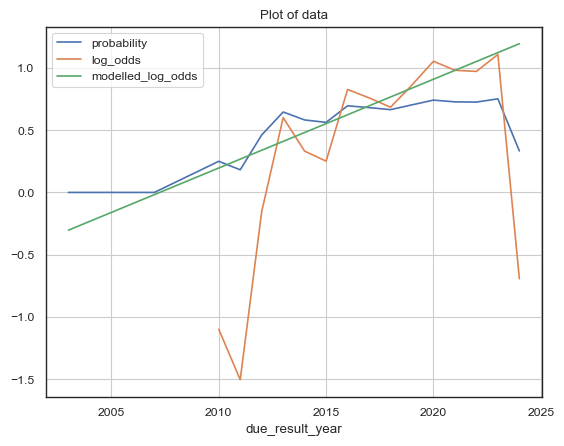

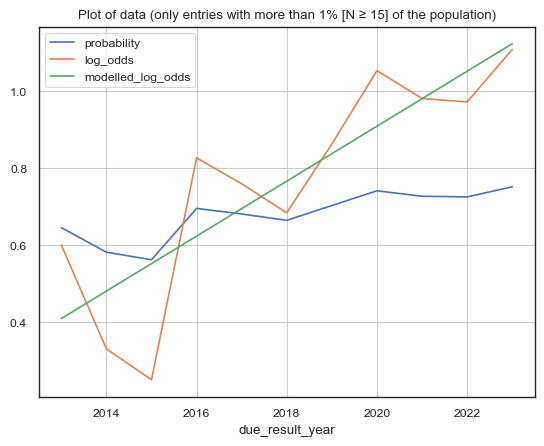

In [26]:
linearity_df = linearity_df.assign(
    modelled_log_odds = linearity_df.index * res.params[continous_variable_grouped] + res.params['const']
)

linearity_df[['probability', 'log_odds', 'modelled_log_odds']].plot(
    grid=True, 
    title='Plot of data'
)
linearity_df.loc[linearity_df['size'] >= len(variables) / 100, ['probability', 'log_odds', 'modelled_log_odds']].plot(
    grid=True, 
    title=f'Plot of data (only entries with more than 1% [N ≥ {np.ceil(len(variables) / 100):.0f}] of the population)'
)

## Multicollinearity Check
We need to check for multicollinearity in the independent variables. We can use `VIF`, `Tolerance`, a Correlation Matrix or `GVIF` (implemented below):

In [27]:
# Adapted from R source code
def gvif(results):
    """
    Calculate GVIF (Generalized Variance Inflation Factor) for regression models.

    Parameters:
    results : statsmodels DiscreteResults
        Fitted regression results.

    Returns:
    DataFrame:
        DataFrame containing GVIF values, degrees of freedom (Df), and GVIF^(1/(2*Df)).
    """
    if results.params.isna().any():
        raise ValueError("There are aliased coefficients in the model")
    
    # v = np.array(results.cov_params())
    v = results.model.exog
    assign = results.model.exog_names
    terms = list(dict.fromkeys([re.sub(r'Q\("(.*?)(__.+)?".*',  r'\1', s) for s in results.model.exog_names]))

    if "Intercept" in assign:
        v = v[1:, 1:]
        assign = assign[1:]
        terms = terms[1:]
    else:
        print("No intercept: GVIFs may not be sensible.")

    n_terms = len(terms)
    if n_terms < 2:
        raise ValueError("Model contains fewer than 2 terms")
    
    # R = np.corrcoef(v)
    R = pd.DataFrame(v).corr().values
    # R = v
    det_R = np.linalg.det(R)
    result = np.zeros((n_terms, 3))
    result_names = ["GVIF", "Df", "GVIF^(1/(2*Df))"]

    for i in range(n_terms):
        subs = [j for j, name in enumerate(assign) if re.sub(r'Q\("(.*?)(__.+)?".*',  r'\1', name) == terms[i]]
        not_subs = np.delete(np.arange(len(R)), subs,)
        result[i, 0] = (np.linalg.det(R[subs][:, subs]) *
                           np.linalg.det(R[not_subs][:, not_subs])) / det_R
        result[i, 1] = len(subs)

    result[:, 2] = result[:, 0]**(1 / (2 * result[:, 1]))

    return pd.DataFrame(result, index=terms, columns=result_names)

gvif_results = gvif(results)
gvif_results

,GVIF,Df,GVIF^(1/(2*Df))
age_population,1.268642,2.0,1.061292
collaboration_with_research_network,1.166237,1.0,1.079925
funding_sources_grouped,2.737708,4.0,1.134158
has_outcomes,1.148009,1.0,1.071452
multiple_funding_sources,1.382809,1.0,1.175929
number_of_countries_grouped,1.260972,1.0,1.122930
number_of_studies_funded_by_biggest_sponsor_quartiles,1.708016,3.0,1.093323
number_of_subjects_grouped,1.692340,4.0,1.067975
planned_duration_quartiles,1.388725,4.0,1.041902
risk_management_plan,2.027533,5.0,1.073240


Next we will add `VIF` and `tolerance`.

In [28]:
# Calculate VIF
vif = {
    name: variance_inflation_factor(results.model.exog, i)
    for i, name in enumerate(results.model.exog_names)
}

# Display VIF, tolerance, GVIF, Df, and GVIF^(1/(2*Df))
pd.DataFrame(vif.items()) \
    .rename(columns={0: 'variables', 1: 'VIF'}) \
    .set_index('variables') \
    .assign(
        tolerance=lambda x : 1 / x['VIF'],
        term=lambda x : [re.sub(r'Q\("(.*?)(__.+)".*',  r'\1', s) for s in x.index]
    ) \
    .drop('Intercept') \
    .merge(
        gvif_results,
        left_on='term', right_index=True
    ) \
    .drop('term', axis='columns')

,VIF,tolerance,GVIF,Df,GVIF^(1/(2*Df))
variables,,,,,
"Q(""age_population__18+_years;_<18_years"")[T.True]",1.240692,0.806002,1.268642,2.0,1.061292
"Q(""age_population__<18_years"")[T.True]",1.110707,0.900327,1.268642,2.0,1.061292
"Q(""collaboration_with_research_network__true"")[T.True]",1.165842,0.857749,1.166237,1.0,1.079925
"Q(""funding_sources_grouped__mixed"")[T.True]",1.423581,0.702454,2.737708,4.0,1.134158
"Q(""funding_sources_grouped__no_funding"")[T.True]",1.052409,0.950201,2.737708,4.0,1.134158
"Q(""funding_sources_grouped__non-commercial"")[T.True]",1.712913,0.583801,2.737708,4.0,1.134158
"Q(""funding_sources_grouped__unclear"")[T.True]",1.114105,0.897582,2.737708,4.0,1.134158
"Q(""has_outcomes__true"")[T.True]",1.148184,0.870941,1.148009,1.0,1.071452
"Q(""multiple_funding_sources__true"")[T.True]",1.383007,0.723062,1.382809,1.0,1.175929


## Finding influental outliers
We will use Cook's distance with a treshold of $4 / \texttt{sample\_size}$ and a treshold of $2$ for the standard residuals to find influental outliers

In [29]:
# Get influence measures
influence = results.get_influence()

# Obtain summary df of influence measures
influence_df = influence.summary_frame()

# Filter summary df to Cook's distance values and standardized residual values only
diagnosis_df = influence_df[['cooks_d', 'standard_resid']]

# Set Cook's distance threshold
cook_threshold = 4 / len(results.model.endog)

# Find observations which are BOTH outlier (|std dev| > 2) and highly influential
extreme = diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) & 
                       (np.abs(diagnosis_df['standard_resid']) > 2)]

extreme.sort_values("cooks_d", ascending=False)

,cooks_d,standard_resid
eu_pas_register_number,,
13438,0.018528,-3.277401
13007,0.017728,-2.563527
16014,0.010534,2.471530
5289,0.008838,2.100547
4290,0.008632,-2.588983
46175,0.008521,-2.199410
49303,0.007134,-2.036651
37438,0.007134,-2.795410
6779,0.006977,2.465409


More details about these studies:

In [30]:
exog.loc[extreme.index].merge(endog, left_index=True, right_index=True, how='left')

,Intercept,"Q(""age_population__18+_years;_<18_years"")[T.True]","Q(""age_population__<18_years"")[T.True]","Q(""collaboration_with_research_network__true"")[T.True]","Q(""funding_sources_grouped__mixed"")[T.True]","Q(""funding_sources_grouped__no_funding"")[T.True]","Q(""funding_sources_grouped__non-commercial"")[T.True]","Q(""funding_sources_grouped__unclear"")[T.True]","Q(""has_outcomes__true"")[T.True]","Q(""multiple_funding_sources__true"")[T.True]",...,"Q(""risk_management_plan__eu_rmp_category_2_(specific_obligation_of_marketing_authorisation)"")[T.True]","Q(""risk_management_plan__eu_rmp_category_3_(required)"")[T.True]","Q(""risk_management_plan__nan"")[T.True]","Q(""risk_management_plan__non-eu_rmp_only"")[T.True]","Q(""studied_medical_conditions__false"")[T.True]","Q(""study_type__clinical_trial"")[T.True]","Q(""study_type__not_applicable"")[T.True]","Q(""uses_established_data_source__true"")[T.True]","Q(""final_report_days_difference"")",has_result
eu_pas_register_number,,,,,,,,,,,,,,,,,,,,,
2181,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4696.0,0.0
3330,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3109.0,1.0
3444,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3774.0,1.0
4290,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2001.0,0.0
5275,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,4519.0,0.0
5289,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3651.0,1.0
5533,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3239.0,0.0
5890,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2598.0,0.0
6033,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2924.0,0.0


We can also visualize Cook's distance with an Index plot and a treshold line:

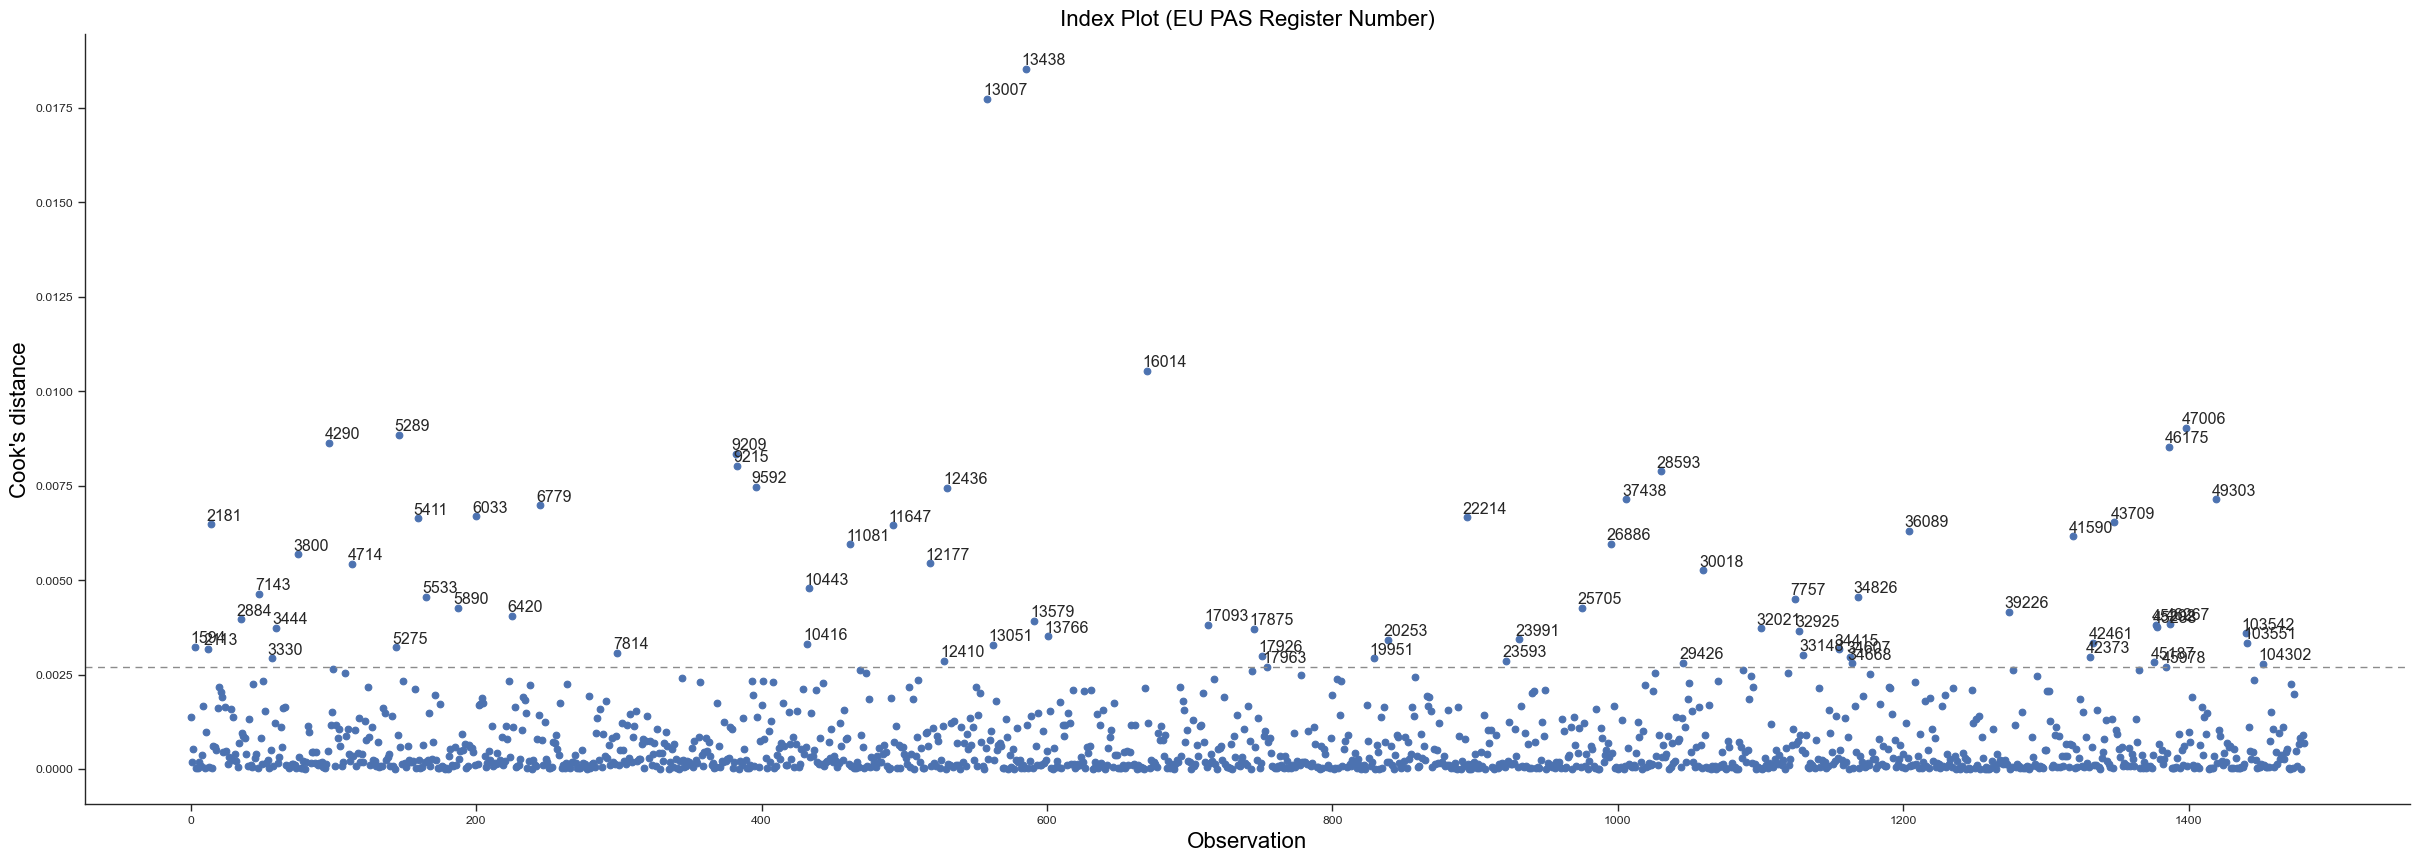

In [31]:
with sns.axes_style("ticks"):
    fig, ax = plt.subplots(figsize=(30,10))
    influence.plot_index(ax=ax, threshold=cook_threshold, title='Index Plot (EU PAS Register Number)')
    plt.axhline(y=cook_threshold,linewidth=1, color=sns.color_palette()[7], dashes=(5,4))
    sns.despine()

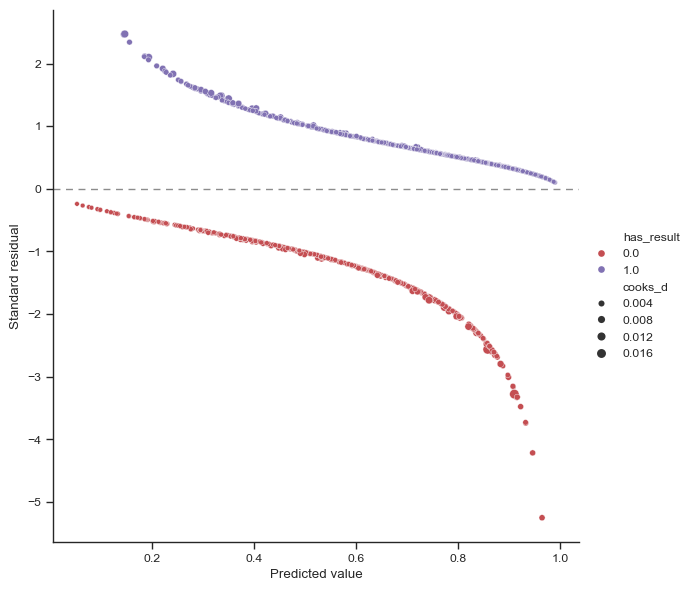

In [32]:
rel = diagnosis_df.assign(predicted=results.predict(), **{results.model.endog_names: results.model.endog})
with sns.axes_style("ticks"):
    sns.relplot(
        data=rel,
        x="predicted", y="standard_resid", # style=results.model.endog_names,
        size="cooks_d", hue=results.model.endog_names,
        height=6, palette=sns.color_palette()[3:5]
    )
    plt.axhline(y=0,linewidth=1, color=sns.color_palette()[7], dashes=(5,4))
    plt.xlabel('Predicted value')
    plt.ylabel('Standard residual')

We get slightly different results with the exclusion of these outliers:

In [33]:
if which == 'results':
   # We have to drop these two observations from the extreme list
   # because the model would not converge without them
   # Both studies are RMP Category 2 Studies (low amount of samples)
   extreme = extreme.drop([13007, 13438], axis='index')

In [34]:
no_extreme_exog = exog.loc[exog.index.difference(extreme.index)]
no_extreme_endog = endog.loc[endog.index.difference(extreme.index)]
no_extreme_results = sm.Logit(no_extreme_endog, no_extreme_exog).fit(maxiter=100)

# Get coefficients with CI
params = no_extreme_results.params
conf_odds_ratio = np.exp(no_extreme_results.conf_int()).rename(columns={0: '[0.025', 1: '0.975]'})

# Calculate Odds Ratio be exponentiating
odds_ratio = np.exp(params).rename('odds rt').to_frame()
odds_ratio_data = np.round(pd.merge(odds_ratio, conf_odds_ratio, left_index=True, right_index=True), decimals=4)

# Append to table
table = SimpleTable(odds_ratio_data.values, odds_ratio_data.columns.to_list())
summary = no_extreme_results.summary()
summary.tables[1].extend_right(table)

no_extreme_logit_df = pd.DataFrame(
    summary.tables[1].data[1:], columns=['name'] + summary.tables[1].data[0][1:]
).set_index('name')

# summary

Optimization terminated successfully.
         Current function value: 0.480386
         Iterations 8


## Sensitivity Analysis

In [12]:
print(f'Number of dates affected by truncation ({exclusive_col}_clipped):', len(variables[variables[exclusive_col] != variables[f'{exclusive_col}_clipped']]))

Number of dates affected by truncation (data_collection_days_difference_clipped): 121


In [35]:
sensitivity_exog = exog.merge(
    variables[f'{exclusive_col}_clipped'].astype(float), 
    left_index=True, 
    right_index=True,
).drop(
    f'Q("{exclusive_col}")', axis='columns'
).rename(
    columns={
        f'{exclusive_col}_clipped': f'Q("{exclusive_col}")'
    }
)
sensitivity_endog = endog
sensitivity_results = sm.Logit(endog, sensitivity_exog).fit(maxiter=100)

# Get coefficients with CI
params = sensitivity_results.params
conf_odds_ratio = np.exp(sensitivity_results.conf_int()).rename(columns={0: '[0.025', 1: '0.975]'})

# Calculate Odds Ratio be exponentiating
odds_ratio = np.exp(params).rename('odds rt').to_frame()
odds_ratio_data = np.round(pd.merge(odds_ratio, conf_odds_ratio, left_index=True, right_index=True), decimals=4)

# Append to table
table = SimpleTable(odds_ratio_data.values, odds_ratio_data.columns.to_list())
summary = sensitivity_results.summary()
summary.tables[1].extend_right(table)

sensitivity_logit_df = pd.DataFrame(
    summary.tables[1].data[1:], columns=['name'] + summary.tables[1].data[0][1:]
).set_index('name')

# summary

Optimization terminated successfully.
         Current function value: 0.515785
         Iterations 6


## Exclusive Column ORs

We will report the OR of the final/exclusive column for a difference of a year:

In [10]:
exclusive_col_results = LogitResults.load(f'../../output/ema_rwd/univariate_models/models/{which}/{exclusive_col}.pickle')

In [37]:
def print_exclusive_col_or_over_multiple_days(res, days=365.25, prefix=''):
    hidden_col = 'Q("' + exclusive_col  + '")'

    x = res.params.loc[hidden_col]
    x_025, x_975 = results.conf_int().loc[hidden_col]

    print(f"{prefix}{exclusive_col} OR [95% CI] for {days} day(s): {np.power(np.e, x * days):.2f} [{np.power(np.e, x_025 * days):.2f}, {np.power(np.e, x_975 * days):.2f}]")

print_exclusive_col_or_over_multiple_days(results, prefix='Default (Multivariate):\n')
print_exclusive_col_or_over_multiple_days(exclusive_col_results, prefix='Default (Univariate):\n')
print_exclusive_col_or_over_multiple_days(no_extreme_results, prefix='No Extremes (Multivariate):\n')
print_exclusive_col_or_over_multiple_days(sensitivity_results, prefix='Sensitivity Analysis (Multivariate):\n')

Default (Multivariate):
final_report_days_difference OR [95% CI] for 365.25 day(s): 0.94 [0.90, 0.98]
Default (Univariate):
final_report_days_difference OR [95% CI] for 365.25 day(s): 0.91 [0.90, 0.98]
No Extremes (Multivariate):
final_report_days_difference OR [95% CI] for 365.25 day(s): 0.92 [0.90, 0.98]
Sensitivity Analysis (Multivariate):
final_report_days_difference OR [95% CI] for 365.25 day(s): 0.94 [0.90, 0.98]


## Predictions
Here are some prediction stats and plots. There is only a small difference between the loaded model and the model without outliers.

In [38]:
def draw_auc(y, predictions):
    fpr, tpr, _ = roc_curve(y, predictions)

    x = np.linspace(0,1,100)

    with sns.axes_style("ticks"):
        plt.plot(fpr,tpr,color=sns.color_palette()[4])
        plt.plot(x,x,color=sns.color_palette()[7], linestyle='dashed')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        sns.despine(trim=True)
        plt.show()


Prediction table:

In [39]:
results.pred_table()

array([[197., 271.],
       [118., 896.]])

Area under Curve:

0.7765123737756874


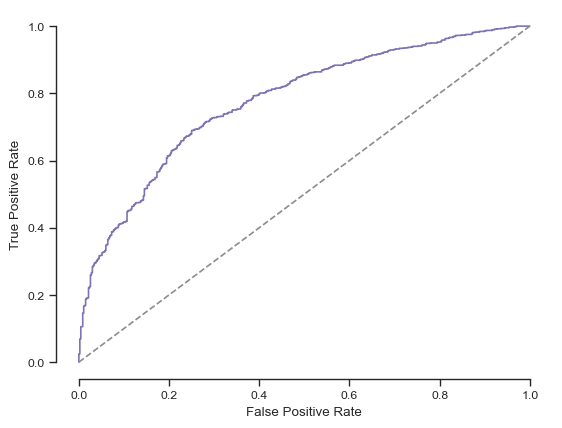

In [40]:
predictions = results.predict()
y = results.model.endog
print(roc_auc_score(y, predictions))
draw_auc(y, predictions)

Prediction table (no extremes):

In [41]:
no_extreme_results.pred_table()

array([[205., 240.],
       [117., 892.]])

Area under Curve (no extremes):

0.8054687586997917


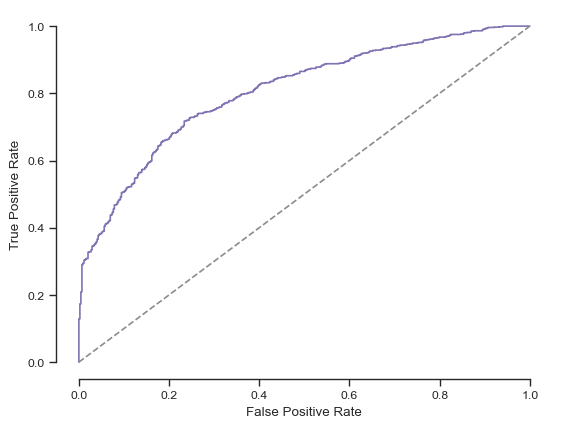

In [42]:
predictions = no_extreme_results.predict()
y = no_extreme_results.model.endog
print(roc_auc_score(y, predictions))
draw_auc(y, predictions)

Prediction table (sensitivity):

In [43]:
sensitivity_results.pred_table()

array([[197., 271.],
       [118., 896.]])

Area under Curve (no extremes):

0.7763248284697989


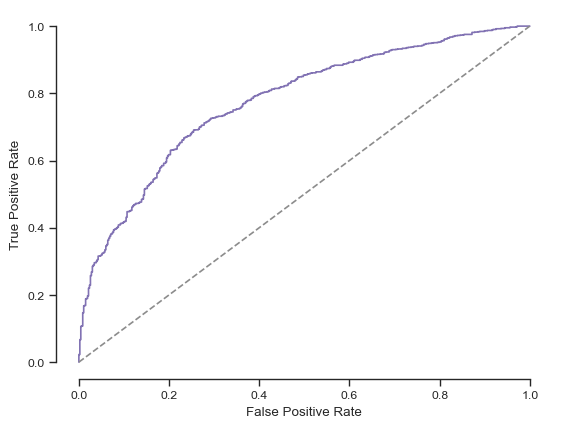

In [44]:
predictions = sensitivity_results.predict()
y = sensitivity_results.model.endog
print(roc_auc_score(y, predictions))
draw_auc(y, predictions)

## Beautify and export summary table
Next we will use the `no_extreme_logit_df` and `sensitivity_logit_df` with the ORs and CIs and `variables` to create a better table.

In [45]:
variables_without_extremes = variables.drop(extreme.index, axis='index')

variables_without_extremes.shape

(1454, 45)

In [46]:
def prettify_logit_df(ugly_df, vars):
    formula_formatter_regex = re.compile(r'Q\("(.*?)"\).*')

    def python_name_converter(x):
            return '_'.join([word.lower() for word in x.split(' ')]) if x[0] != '$' else x

    def transform_logit_table(df):
        df = df.drop('Intercept').reset_index()

        df['name'] = df['name'].str.replace(
            formula_formatter_regex, r'\1',
            regex=True
        )

        df = df.assign(
            variable=df['name'].str.split('__').str[0],
            value=df['name'].str.split('__').str[1]
        )

        df = pd.concat([
            df.iloc[:, :5],
            df.iloc[:, 7:]
        ],
            axis='columns'
        )

        df['odds rt'] = df['odds rt'].round(2).map('{:,.2f}'.format) + ' (' + \
            df['[0.025'].round(2).map('{:,.2f}'.format) + ' - ' + \
            df['0.975]'].round(2).map('{:,.2f}'.format) + ')'

        df = df.drop(
            [
                'coef', 'std err',
                'z', '[0.025', '0.975]'
            ],
            axis='columns'
        ).dropna(subset=['value'])

        df = df.rename(columns={
            'P>|z|': 'P value multivariate',
            'odds rt': 'OR (95% CI) multivariate'
        })

        return df[df.columns[::-1]]

    pretty_df = transform_logit_table(ugly_df)

    frequencies = pd.DataFrame()
    for var in pretty_df['variable'].unique():
        # NOTE: The NA Values have to be filled with 'nan' to merge values correctly
        # We will rename this later
        crosstab = pd.crosstab(
            vars[var].fillna(str(np.nan)),
            vars['has_protocol' if which == 'protocol' else 'has_result'],
            rownames=['value'],
            margins=True,
            margins_name='N'
        )

        if var == 'planned_duration_quartiles':
            crosstab = crosstab.rename(
                index = {
                    float(i): int(i)
                    for i in range(1, 5)
                }
            )
        elif var == 'requested_by_regulator':
            crosstab = crosstab.rename(
                index = {
                    0: False,
                    1: True
                }
            )
        
        frequencies = pd.concat([
            frequencies,
            crosstab
            .drop(columns=[False])
            .drop(index=['N'])
            .assign(
                variable=var,
                relative=lambda x: x[True] / x['N']
            )
            .reset_index()
            .rename(
                columns={
                    True: 'absolute'
                }
            )
        ])

    frequencies = frequencies.assign(
        **{
            'n (%)': lambda x: x['absolute'].astype(str) + ' ('
            + (x['relative'] * 100).round(1).astype(str) + ')'
        },
        name=lambda x: x['variable'].astype(str) + '__'
        + x['value'].astype(str).map(python_name_converter)
    ).drop(['absolute', 'relative'], axis='columns')

    pretty_df = pd.merge(
        frequencies,
        pretty_df.drop(['variable', 'value'], axis='columns'),
        on='name',
        how='left'
    ).drop(
        ['name'],
        axis='columns'
    )


    # NOTE: Quickfix to prevent dtype changes for planned_duration_quartiles
    # NOTE: This will also change the bool value names
    pretty_df['value'] = pretty_df['value'].astype(str).map(
        lambda x: 'Not available' if x == 'nan' else x
    )

    pretty_df = pretty_df.set_index(['variable', 'value']).sort_index()

    return pretty_df

In [47]:
pretty_no_extreme_logit_df = prettify_logit_df(no_extreme_logit_df, variables_without_extremes)
pretty_no_extreme_logit_df

N  \
variable                                           value                                                      
age_population                                     18+ years                                            943   
                                                   18+ years; <18 years                                 417   
                                                   <18 years                                             94   
collaboration_with_research_network                False                                               1311   
                                                   True                                                 143   
funding_sources_grouped                            Commercial                                          1142   
                                                   Mixed                                                 39   
                                                   No Funding                                            13   
                                                   Non-Commercial                                       238   
                                                   Unclear                                               22   
has_outcomes                                       False                                                267   
                                                   True                                                1187   
multiple_funding_sources                           False                                               1323   
                                                   True                                                 131   
number_of_countries_grouped                        Multiple Countries                                   561   
                                                   Single Country                                       893   
number_of_studies_funded_by_biggest_sponsor_qua... 1                                                    363   
                                                   2                                                    389   
                                                   3                                                    386   
                                                   4                                                    316   
number_of_subjects_grouped                         100-<500                                             318   
                                                   1000-10000                                           339   
                                                   500-<1000                                            143   
                                                   <100                                                 161   
                                                   >10000                                               493   
planned_duration_quartiles                         1                                                    291   
                                                   2                                                    288   
                                                   3                                                    287   
                                                   4                                                    291   
                                                   Not available                                        297   
risk_management_plan                               EU RMP category 1 (imposed as condition of mark...    62   
                                                   EU RMP category 2 (specific obligation of marke...    19   
                                                   EU RMP category 3 (required)                         394   
                                                   Non-EU RMP only                                       79   
                                                   Not applicable                                       843   

In [48]:
pretty_no_extreme_logit_df.to_excel(f"ema_rwd_final_statistics_tables_logit_without_outliers_due_{'protocol' if which == 'protocol' else 'result'}.xlsx")

In [49]:
pretty_sensitivity_logit_df = prettify_logit_df(sensitivity_logit_df, variables)
pretty_sensitivity_logit_df

N  \
variable                                           value                                                      
age_population                                     18+ years                                            955   
                                                   18+ years; <18 years                                 428   
                                                   <18 years                                             99   
collaboration_with_research_network                False                                               1338   
                                                   True                                                 144   
funding_sources_grouped                            Commercial                                          1160   
                                                   Mixed                                                 40   
                                                   No Funding                                            14   
                                                   Non-Commercial                                       246   
                                                   Unclear                                               22   
has_outcomes                                       False                                                274   
                                                   True                                                1208   
multiple_funding_sources                           False                                               1347   
                                                   True                                                 135   
number_of_countries_grouped                        Multiple Countries                                   577   
                                                   Single Country                                       905   
number_of_studies_funded_by_biggest_sponsor_qua... 1                                                    373   
                                                   2                                                    390   
                                                   3                                                    393   
                                                   4                                                    326   
number_of_subjects_grouped                         100-<500                                             320   
                                                   1000-10000                                           347   
                                                   500-<1000                                            146   
                                                   <100                                                 168   
                                                   >10000                                               501   
planned_duration_quartiles                         1                                                    297   
                                                   2                                                    293   
                                                   3                                                    294   
                                                   4                                                    295   
                                                   Not available                                        303   
risk_management_plan                               EU RMP category 1 (imposed as condition of mark...    68   
                                                   EU RMP category 2 (specific obligation of marke...    19   
                                                   EU RMP category 3 (required)                         401   
                                                   Non-EU RMP only                                       81   
                                                   Not applicable                                       853   

In [50]:
pretty_sensitivity_logit_df.to_excel(f"ema_rwd_final_statistics_tables_logit_sensitivity_due_{'protocol' if which == 'protocol' else 'result'}.xlsx")